# PHY 68 Project 3: Ising Model

By: 

List of libraries to import:

In [27]:
%matplotlib inline
from __future__ import division
import numpy as np
import numpy.random as random
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.animation as animation
import numba
import copy
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from IPython.display import Video
from matplotlib.colors import ListedColormap

### Classes and Functions For Our Model:

We created several different classes: a Lattice class to contain the lattice information, a Metropolis class that contains the Metropolis algorithm and functions needed to run and display it, a Swendsen- class for the SW algorithm, and two functions needed to find Tc for the lattice and plot the temperature vs. magnetism graphs.

In [28]:
# Lattice class

class Lattice:
    
    '''
    constructor function
    inputs: J: the J value for the material
            N: the length of the sides of the lattice
            dim: the dimensions of the lattice -- either 1 or 2
            shape: the shape of the lattice: if True, triangle; if False, square
            holes: the probability of a hole appearing at a given spot on the lattice
    '''
    
    def __init__(self, J, N = 10, dim = 2, shape = False, holes = 0):
        self.J = J
        self.N_x = N
        self.shape = shape
        self.dim = dim
        
        # if the dimensions are one, lattice is a line
        if dim == 1:
            self.N_y = 1
        else:
            self.N_y = N
            
        # creates a NxN_y array of values that are either -1 or 1
        # selected randomly
        
        self.config = 2*np.random.randint(2, size=(N,self.N_y))-1
        
        # creates a triangle by placing zeroes on the left-bottom
        # half of the lattice
        
        if (self.shape == True):
            for i in range(self.N_x):
                for j in range(self.N_y - i):
                    self.config[i, j] = 0
                    
        # randomly places holes based on the hole probability           
        if (holes != 0):
            for i in range(self.N_x):
                for j in range(self.N_y):
                    if (random.random() < holes):
                        self.config[i, j] = 0
                    
    '''
    get_delta
    inputs: x: the x index
            y: the y index
            sign: the sign of that index (either -1, 1, or 0)
    purpose: find the change in energy that comes from changing the sign
             of the element at (x, y)
    '''
                    
    def get_delta(self, x, y, sign):
        # find the energy after the sign has changed -- we only need to consider its neighbors
        # since all of the others will remain unchanged
        neighbors = self.config[(x+1)%self.N_x,y] + self.config[x,(y+1)%self.N_y] + self.config[(x-1)%self.N_x,y] + self.config[x,(y-1)%self.N_y]
                    
        if (self.shape == True):
            neighbors += self.config[(x-1)%self.N_x, (y + 1)%self.N_y] + self.config[(x+1)%self.N_x, (y - 1)%self.N_y]
                    
        # the change in energy is just 2*J*sign*(energy of neighbors) since the energy of the neighbors
        # before would be -1*neighbors, so after - before = J*sign*(neighbors + neighbors) = 2J*sign*(neighbors)
        
        return 2*self.J*sign*neighbors
    
    '''
    getM
    inputs: N/A
    purpose: find the total magnetism of the lattice
    '''        
    def getM(self):
        mag = np.sum(self.config)
        return mag
    

In [29]:
# Metropolis Class: Runs the Metropolis Algorithm

class Metropolis():
    
    '''
    Constructor function
    inputs: lat: the given lattice
            T: the given temperature
            sign: the sign of that index (either -1, 1, or 0)
    '''
    
    def __init__(self, lat, T):
        self.T = T
        self.lat = lat
        
    '''
    update_lat
    inputs: beta: 1 / T (I was lazy)
    purpose: to update the lattice using the Metropolis algorithm
    '''
        
    def update_lat(self, beta):
        curr_lat = self.lat
        
        # go through the lattice and find a random index (x, y)
        # find the change in energy from flipping its sign
        # change it if the change is negative or if a random
        # number is less than a specific probability related to T
        
        for i in range(curr_lat.N_x):
            for j in range(curr_lat.N_y):            
                    x = np.random.randint(0, curr_lat.N_x)
                    y = np.random.randint(0, curr_lat.N_y)
                    sign =  curr_lat.config[x, y]
                    
                    delta = curr_lat.get_delta(x, y, sign)
                    
                    if delta < 0:
                        sign *= -1
                    elif rand() < np.exp(-delta*beta):
                        sign *= -1
                        
                    # either keep or change the sign
                    curr_lat.config[x, y] = sign
        return curr_lat.config
    
    '''
    run_metropolis
    inputs: steps: number of iterations
            path: the animation pathway
            display: whether or not to show an animation
    purpose: to run the Metropolis algorithm a specific number
             of iterations and potentially print an animation
    '''
    
    def run_metropolis(self, steps, path, display=False):
        graph_snapshots_array = []
        beta = 1.0/self.T
        
        for i in range(steps):
            self.update_lat(beta)
            graph_snapshots_array.append(self.lat.config.copy())
        
        if display:
            self.visualizer(graph_snapshots_array, self.T, path,)
            
    '''
    visualizer
    inputs:
    purpose: 
    '''
    def visualizer(self, graph_snapshots_array, T, path):
        fps = 30
        nSeconds = 5
        snapshots = graph_snapshots_array

        # First set up the figure, the axis, and the plot element we want to animate
        fig = plt.figure( figsize=(8,8) )

        a = snapshots[0]
        im = plt.imshow(a, interpolation='none', aspect='auto',)
        
        #helper function
        def animate_func(i):
            if i % fps == 0:
                print( '.', end ='' )

            im.set_array(snapshots[i])
            plt.title('Temperature : '+ str(T))
            return [im]

        anim = animation.FuncAnimation(
                                        fig, 
                                        animate_func, 
                                        frames = nSeconds * fps,
                                        interval = 1000 / fps, # in ms
                                        )

        anim.save(path, fps=fps, extra_args=['-vcodec', 'libx264'])
        plt.close()
            
    
    '''
    plt_mag_iter
    inputs: steps: number of iterations
            T: temperature
            display: whether or not to show an animation
    purpose: to plot the magnetism over the number of iterations
    '''

    
    def plt_mag_iter(self, steps, T):
        self.T = T
        # we will find the magnetism of the lattice every 100 steps
        iter_steps = np.linspace(0, steps, int(steps/100)); 
        magnetism = np.zeros(int(steps / 100))
        
        for i in range(0, steps, 100):
            total_mag = 0
            curr_lat = self.lat
            curr_lat.config = 2*np.random.randint(2, size=(curr_lat.N_x,curr_lat.N_y))-1
            beta =1.0/self.T
            
            # run Metropolis for each iteration and find the magnetism at the end
            for j in range(i):
                self.update_lat(beta)
                
                mag = curr_lat.getM()
                total_mag += mag
            
            # add average magnetism to the array
            if (i != 0):
                magnetism[int(i / 100)] = total_mag / (i * curr_lat.N_x * curr_lat.N_y)
            else:
                magnetism[int(i / 100)] = total_mag / (curr_lat.N_x * curr_lat.N_y)
        
        # plot
        fig = plt.figure(figsize=(8, 4))
        plt.scatter(iter_steps, abs(magnetism))
        plt.xlabel("# of Iterations at Temp " + str(self.T))
        plt.ylabel("Magnetization ")
        
        
    '''
    plt_mag_t
    inputs: num: number of points on graph
            steps: number of iterations
    purpose: to plot temperature vs. magnetism
    '''
    
    def plt_mag_t(self, num, steps):
        if (self.lat.dim == 1):
            temp_steps = np.linspace(0.1, 4, num)
        elif (self.lat.shape == False):
            temp_steps = np.linspace(1, 4, num)
        else:
            temp_steps = np.linspace(2.5, 5.5, num)
        magnetism = np.zeros(num)
        
        # find the average magnetism at each temperature and add to magnetism array
        for i in range(num):
            total_mag = 0
            curr_lat = self.lat
            curr_lat.config = 2*np.random.randint(2, size=(curr_lat.N_x,curr_lat.N_y))-1
            beta =1.0/temp_steps[i]
            
            for j in range(steps):
                self.update_lat(beta)      
                
                mag = curr_lat.getM()
                total_mag += mag

            magnetism[i] = total_mag / (steps * curr_lat.N_x * curr_lat.N_y)
            
        # plot and find Tc
        fit(temp_steps, abs(magnetism))
            

In [30]:
#extra functions 
    
'''
f
inputs: x, k, w, x0, y0: constants for arctan graph
purpose: arctan function
'''

def f(x, k, w, x0, y0):
    return k * np.arctan(w*(x-x0)) + y0
    
    
'''
fit
inputs: xdata, ydata: the data that will be graphed on the
                    x and y axes
purpose: plot data and fit an arctan curve to it
'''

def fit(xdata, ydata):
    p0 = [1, 1]
    p0.append(0.5*(max(xdata)+min(xdata)))
    p0.append(0.5*(max(ydata)+min(ydata)))
    output = curve_fit(f, xdata, ydata, p0=p0, full_output=True)
    
    coef = output[0]
    xi = np.linspace(min(xdata), max(xdata), 100)
    yi = f(xi, *coef)
    
    tc = '%.3f'%find_Tc(coef[0], coef[1], coef[2], coef[3])
    plt.xlabel('Temperature', fontsize=12)
    plt.ylabel('Magnetism', fontsize=12)
    plt.title("Magnetism vs. Temperature (Tc = " + str(tc) + " )")
    plt.scatter(xdata, ydata)
    plt.plot(xi, yi, linestyle=':')
    
'''
find_Tc
inputs: x, k, w, x0, y0: constants for arctan graph
purpose: to calculate what Tc is for a given lattice,
         which will be when magnetism = 0.5 since that is
         halfway between 1 and 0
'''

def find_Tc(k, w, x0, y0):
    return ((np.tan((0.5 - y0) / k)) / w) + x0

### Visualizations and Analysis

#### Magnetism vs. Iterations at Different Temperatures

First, let us assess how many iterations it takes for a square lattice to stabilize at a specific magnetism

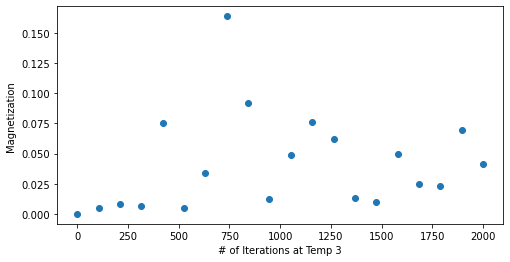

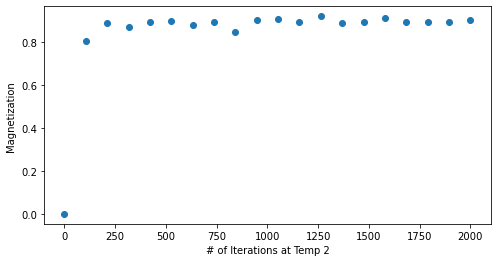

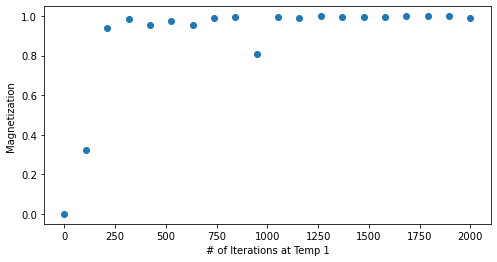

In [31]:
square_lat = Lattice(1)
square_met = Metropolis(square_lat, 2)
square_met.plt_mag_iter(2000, 3)
square_met.plt_mag_iter(2000, 2)
square_met.plt_mag_iter(2000, 1)

It appears that at lower temperatures, it stablizes a lot quicker than it does at higher temperatures and is a lot more consistent. In general, around 2000 iterations seems to be ideal to ensure that at higher temperatures the lattice is as stable as it can be.

#### Magnetism vs. Temperature

Even looking at the iterations above, it appears that at low temperatures, the average magnetism is 1, and as it goes towards higher temperatures, it goes towards 0.

We will examine a couple different Magnetism vs. Temperature graphs and find the temperature where the magnetism switches (i.e. Tc) for each of them. First, let us examine the square lattice, the most basic form.

In [32]:
square_met.T = 3
square_met.run_metropolis(1000, 'Square_met_anim.mp4', True)
Video('Square_met_anim.mp4')

......

In [33]:
square_met.plt_mag_t(100, 2000)

KeyboardInterrupt: 

Here, we see that Tc ~ 2.2 - 2.3. We chose to use an arctan curve fit since we thought the curve most resembled that function. There is obviously room for error considering the outliers around the middle, but overall it seems to fit fairly well. 

Now, let us see if a one-dimensional lattice is any different.

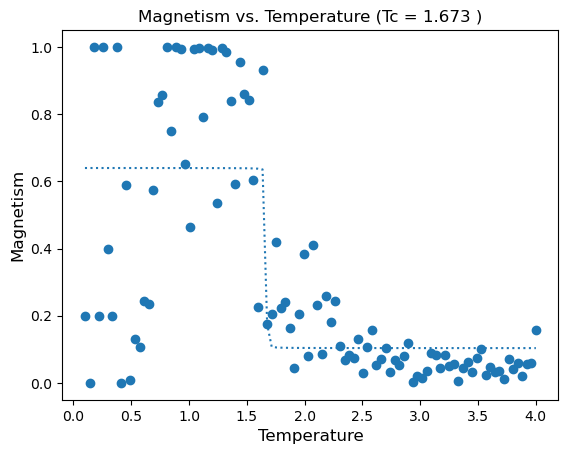

In [ ]:
one_lat = Lattice(1, dim = 1)
met_one = Metropolis(one_lat, 2)
met_one.plt_mag_t(100, 2000)

We see that while Tc ~ 1.6 - 1.8, the fit is less accurate, probably owing to the fact that there are fewer elements in the lattice and there are fewer bonds to consider, which will also cause Tc to be lower than it was in the square lattice.

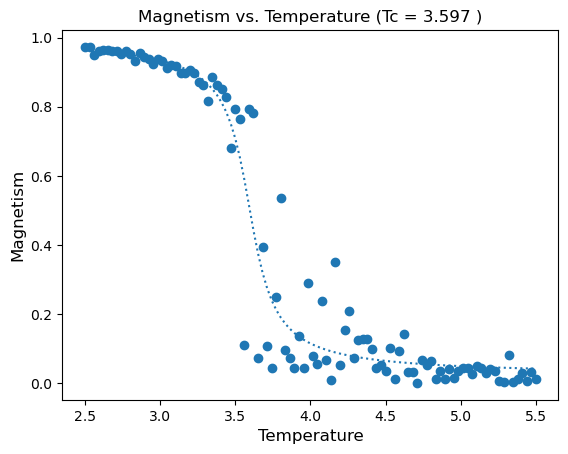

In [ ]:
tri_lat = Lattice(1, shape = True)
met_tri = Metropolis(tri_lat, 2)
met_tri.plt_mag_t(100, 2000)

It is interesting to see how Tc for the triangle lattice is actually higher (Tc ~ 3.6) than the square lattice even though it has fewer lattice points. This is most likely because the triangle lattice has more bonds, so it will take a higher temperature / more energy to reach the paramagnetic state

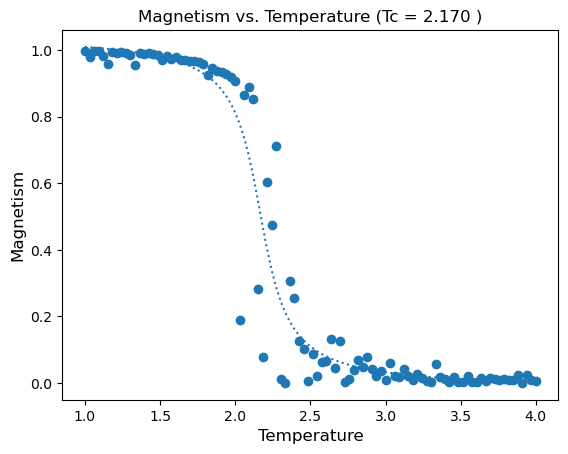

In [ ]:
hole_lat = Lattice(1, holes = 1)
met_holes = Metropolis(hole_lat, 2)
met_holes.plt_mag_t(100, 2000)

## this should not look like this?? gonna investigate more
